In [1]:
# import pyarrow

import pandas as pd
import numpy as np

from scipy.stats import pearsonr
from tqdm.notebook import trange, tqdm

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# 1. Clean Data

In [2]:
# Access data
parquet_file = 'data/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=0/part-0.parquet'
df = pd.read_parquet(parquet_file, engine="pyarrow")

In [3]:
# combine date_id and time_id to create a time-based sequence variable
shrink = 10000
id = (df['date_id']/shrink)*(max(df['time_id'])+1) + df['time_id']/shrink # the base is max(df['time_id'])+1; similar to base 10 system
df['seq_id'] = id
df = df.reindex(columns=['seq_id'] + list(df.columns[:-1]))
df.drop(columns=['date_id', 'time_id'], inplace=True)

In [4]:
# Normalize and impute NaN with -1 after min/max norm
def minmax_neg1nan(df):
    # Find the columns not containing "id" in their name
    norm_columns = [col for col in df.columns if "id" not in col]
    norm_columns.remove('weight') # probably good to keep weight as is

    # Min-Max Normalisation to [0,1] for non-id nor weight columns
    df[norm_columns] = df[norm_columns].apply(lambda col: (col - col.min()) / (col.max() - col.min()))

    # fill NaN values with -1
    df.fillna(-1, inplace=True)

    return df
df = minmax_neg1nan(df)
df.head()

,seq_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,...,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8
0,0.0,1,3.889038,-1.0,-1.0,-1.0,-1.0,-1.0,0.465815,0.514922,...,0.066075,0.573849,0.493044,0.638087,0.700535,0.518602,0.621837,0.577598,0.534700,0.509550
1,0.0,7,1.370613,-1.0,-1.0,-1.0,-1.0,-1.0,0.459389,0.513077,...,0.065630,0.796589,0.619008,0.447600,0.884992,0.762698,1.000000,0.570367,0.521668,0.577864
2,0.0,9,2.285698,-1.0,-1.0,-1.0,-1.0,-1.0,0.473393,0.513791,...,0.069997,0.413551,0.471970,0.467330,0.537578,0.627129,0.509979,0.710935,0.567088,0.577283
3,0.0,10,0.690606,-1.0,-1.0,-1.0,-1.0,-1.0,0.476461,0.515538,...,0.065762,0.540850,0.522399,0.729489,0.609744,0.622587,0.622538,0.611414,0.577520,0.362048
4,0.0,14,0.440570,-1.0,-1.0,-1.0,-1.0,-1.0,0.469661,0.515316,...,0.144631,0.462661,0.449724,0.465198,0.107185,0.340863,0.000000,0.142718,0.391088,0.000000


In [5]:
# drop responders (other than responder 6) from df
df.drop(columns=[f"responder_{i}" for i in [0,1,2,3,4,5,7,8]], inplace=True)
df.head()

,seq_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,...,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_6
0,0.0,1,3.889038,-1.0,-1.0,-1.0,-1.0,-1.0,0.465815,0.514922,...,0.010971,0.005625,0.006320,-1.0,-1.0,0.081308,0.078341,0.066610,0.066075,0.577598
1,0.0,7,1.370613,-1.0,-1.0,-1.0,-1.0,-1.0,0.459389,0.513077,...,0.010513,0.002409,0.005603,-1.0,-1.0,0.080878,0.078968,0.068394,0.065630,0.570367
2,0.0,9,2.285698,-1.0,-1.0,-1.0,-1.0,-1.0,0.473393,0.513791,...,0.013406,0.003304,0.005881,-1.0,-1.0,0.095183,0.089571,0.071146,0.069997,0.710935
3,0.0,10,0.690606,-1.0,-1.0,-1.0,-1.0,-1.0,0.476461,0.515538,...,0.018484,0.032793,0.017134,-1.0,-1.0,0.082058,0.077466,0.068990,0.065762,0.611414
4,0.0,14,0.440570,-1.0,-1.0,-1.0,-1.0,-1.0,0.469661,0.515316,...,0.009153,0.005315,0.006302,-1.0,-1.0,0.166908,0.144226,0.125198,0.144631,0.142718


In [6]:
# Choose a subset of 10 features with closest simarility to the target: responder 6
def subset_features(df, n):
    corr_list = []
    n_cols = df.shape[1]
    x = df["responder_6"]
    for i in tqdm(range(3, n_cols-1)): # exclude responder 6 at end
        y = df.iloc[:, i] # column i
        mask = ~np.isnan(x) & ~np.isnan(y) # mask out NaN values
        corr = np.nan if len(y[mask]) < 2 else abs(pearsonr(x[mask], y[mask]).correlation)
        corr_list.append(tuple([i, corr]))

    # sort column indices by most -> least correlated, take top n
    out_tuple = sorted(
        corr_list,
        key=lambda x: (np.isnan(x[1]), -x[1] if not np.isnan(x[1]) else float("-inf")),
        reverse=False,
    )[:n]

    out = [x[0] for x in out_tuple]

    return sorted(out) # return in index order

In [7]:
subset_n = 10
subset_columns = [0,1,2] + subset_features(df, n=subset_n) + [df.columns.get_loc("responder_6")]

split_ratio = 0.8
train_df = df.iloc[:int(len(df)*split_ratio), subset_columns]
test_df = df.iloc[int(len(df)*split_ratio):, subset_columns]

  0%|          | 0/79 [00:00<?, ?it/s]

/var/folders/17/363kc2_n4bdg1h6hdx82d81h0000gn/T/ipykernel_87068/78671977.py:9: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr = np.nan if len(y[mask]) < 2 else abs(pearsonr(x[mask], y[mask]).correlation)


In [8]:
train_df.head()

,seq_id,symbol_id,weight,feature_05,feature_06,feature_07,feature_19,feature_39,feature_51,feature_53,feature_56,feature_68,feature_69,responder_6
0,0.0,1,3.889038,0.465815,0.514922,0.425142,0.279095,-1.0,0.449066,-1.0,0.264526,0.002818,0.010717,0.577598
1,0.0,7,1.370613,0.459389,0.513077,0.423677,0.281537,-1.0,0.544227,-1.0,0.338956,0.003411,0.009337,0.570367
2,0.0,9,2.285698,0.473393,0.513791,0.424863,0.246460,-1.0,0.481614,-1.0,0.234111,0.002999,0.008997,0.710935
3,0.0,10,0.690606,0.476461,0.515538,0.426033,0.350599,-1.0,0.666179,-1.0,0.410094,0.008494,0.014574,0.611414
4,0.0,14,0.440570,0.469661,0.515316,0.426816,0.290998,-1.0,0.552196,-1.0,0.414646,0.002691,0.011307,0.142718


In [9]:
test_df.head()

,seq_id,symbol_id,weight,feature_05,feature_06,feature_07,feature_19,feature_39,feature_51,feature_53,feature_56,feature_68,feature_69,responder_6
1555368,12.1925,33,1.301134,0.439631,0.511814,0.423044,0.494335,0.256487,0.450238,0.522075,0.495673,0.001625,0.009133,0.516518
1555369,12.1925,34,1.437518,0.440414,0.512207,0.422065,0.485144,0.595078,0.339397,0.573141,0.556594,0.001830,0.009276,0.428489
1555370,12.1925,38,1.926398,0.438835,0.511766,0.421562,0.252044,0.473257,0.214426,0.557326,0.486511,0.001676,0.008339,0.456160
1555371,12.1926,0,2.116013,0.442453,0.515137,0.422550,0.516998,0.387863,0.438227,0.588736,0.511437,0.001664,0.011333,0.463442
1555372,12.1926,1,3.343626,0.440680,0.512819,0.422627,0.445221,0.369758,0.239692,0.550703,0.574810,0.001880,0.010765,0.545143


# 2. Reformat Data to Multiple Tensors for Pickeling

In [10]:
symbols = train_df['symbol_id'].unique() # based on train symbols
symbols.sort()

seq_ids_train = train_df['seq_id'].unique()
seq_ids_test = test_df['seq_id'].unique()

def create_tensor_from_df(df, seq_ids, sym):
    # filter for symbol
    symbol_df = df[df.symbol_id==sym]

    # Add additional rows for all seq_ids that are missing
    missing_seq_ids = np.setdiff1d(seq_ids, symbol_df.seq_id.unique())
    missing_rows = pd.DataFrame({
        'seq_id': missing_seq_ids, 
        'symbol_id': [sym]*len(missing_seq_ids),
        })
    for col in df.columns:
        if col not in missing_rows.columns:
            missing_rows[col] = np.nan

    # Horizontally concatenate the two DataFrames
    symbol_df = pd.concat([symbol_df, missing_rows], axis=0, ignore_index=True)

    # Sort the DataFrame by 'seq_id' to maintain order
    symbol_df = symbol_df.sort_values(by='seq_id').reset_index(drop=True)
    
    # Impute NaNs with the previous values
    symbol_df.iloc[0] = symbol_df.iloc[0].fillna(-1) # fill first nan values with -1
    symbol_df = symbol_df.fillna(method='ffill')

    # Extract feature columns -> np.arrays
    n_cols = symbol_df.shape[1]
    features_arrs = []
    for i in range(2, n_cols): # exclude seq_id and symbol_id
        arr = symbol_df.iloc[:,i].to_numpy()
        features_arrs.append(arr)

    # stack into a tensor
    stacked_features = np.column_stack(features_arrs)
    tensor_features = torch.tensor(stacked_features)
    
    return tensor_features


for sym in symbols:
    train_tensor_features = create_tensor_from_df(train_df, seq_ids_train, sym)
    test_tensor_features = create_tensor_from_df(test_df, seq_ids_test, sym)

    # pickle and save
    f_train = f"./data/pickled_data/symbol{sym}_train.pt"
    f_test = f"./data/pickled_data/symbol{sym}_test.pt"
    torch.save(train_tensor_features, f_train)
    torch.save(test_tensor_features, f_test)


/var/folders/17/363kc2_n4bdg1h6hdx82d81h0000gn/T/ipykernel_87068/3123175601.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  symbol_df = pd.concat([symbol_df, missing_rows], axis=0, ignore_index=True)
/var/folders/17/363kc2_n4bdg1h6hdx82d81h0000gn/T/ipykernel_87068/3123175601.py:29: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  symbol_df = symbol_df.fillna(method='ffill')
/var/folders/17/363kc2_n4bdg1h6hdx82d81h0000gn/T/ipykernel_87068/3123175601.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the res

# 3. Create Model

In [11]:
# Define a residual MLP block (same as before)
class ResBlockMLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(ResBlockMLP, self).__init__()
        self.norm1 = nn.LayerNorm(input_size)
        self.fc1 = nn.Linear(input_size, input_size // 2)
        self.norm2 = nn.LayerNorm(input_size // 2)
        self.fc2 = nn.Linear(input_size // 2, output_size)
        self.fc_skip = nn.Linear(input_size, output_size)
        self.act = nn.ELU()


    def forward(self, x):
        # overall structure: input -> norm -> act -> skip
        #                    input -> norm -> act -> fc1 -> norm -> act -> fc2
        #                    return skip + fc2
        x = self.act(self.norm1(x))
        skip = self.fc_skip(x)
        x = self.fc2(self.act(self.norm2(self.fc1(x))))
        return x + skip


class LSTM(nn.Module):
    def __init__(self, seq_len, n_cols, num_blocks=1, hidden_size = 128): # NOTE: removed buffer_size arg from RNN class
        super(LSTM, self).__init__()

        # calculate sequence length after flatten
        seq_data_len = seq_len * n_cols

        # Same as with mlp before
        self.input_mlp = nn.Sequential(
            nn.Linear(seq_data_len, 4 * seq_data_len),
            nn.ELU(),  
            nn.Linear(4 * seq_data_len, hidden_size) 
        )

        # Define LSTM block
        self.lstm = nn.LSTM(input_size = hidden_size, hidden_size = hidden_size, num_layers = num_blocks, batch_first=True) 

        blocks = [ResBlockMLP(hidden_size, hidden_size) for _ in range(num_blocks)]
        self.res_blocks = nn.Sequential(*blocks)
        self.act = nn.ELU()
        self.fc_out = nn.Linear(hidden_size, n_cols) # predict 1 day for n columns

    def forward(self, input_seq, hidden_in, mem_in):
        # flatten
        B,_,_ = input_seq.shape
        input_seq = torch.reshape(input_seq, (B, -1))

        # Pass through MLP
        input_vec = self.input_mlp(input_seq)
        input_vec = input_vec.unsqueeze(1)

        # Pass through LSTM
        output, (hidden_out, mem_out) = self.lstm(input_vec, (hidden_in, mem_in))

        # Pass LSTM output through residual blocks
        x = self.act(self.res_blocks(output)).squeeze(0)
        x = self.fc_out(x)

        # Compute the final output
        return x, hidden_out, mem_out

In [12]:
# create dataloader
class StockDataset(Dataset):
    def __init__(self, f, seq_len=100):
        self.seq_len = seq_len
        self.data = torch.load(f)
    def __len__(self): # number input output combos
        return len(self.data) - self.seq_len
    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_len,:11]
        y = self.data[idx+self.seq_len,:11]
        return x, y

def get_dataloader(f, seq_len=100, batch_size=32):
    dataset = StockDataset(f, seq_len)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
    return dataloader

In [13]:
# Train model
seq_len = 100 # train 100 rows at a time
no_cols = subset_n + 1 # 10 features + 1 weight
seq_out_size = 12 # predict 12 columns for 1 day
batch_size = 32
hidden_size = 128
stock_lstm = LSTM(seq_len, no_cols, seq_out_size, hidden_size=hidden_size)

# Define optimizer
lr = 0.001
optimizer = optim.Adam(stock_lstm.parameters(), lr=lr)

# Define loss function
loss_fn = nn.MSELoss()

# loss logger
testing_rate = 900
loss_log = {str(sym):[] for sym in symbols}

for sym in symbols:
    print("Training for symbol", sym)
    # Load pickled data
    f_train = f"./data/pickled_data/symbol{sym}_train.pt"
    train_dataloader = get_dataloader(f_train, seq_len=seq_len, batch_size=batch_size)
    train_dataloader_iterator = iter(train_dataloader)

    epochs = len(train_dataloader) # Number of batches, i.e. Number of Examples / Batch Size
    for epoch in tqdm(range(epochs), "Training Epochs"):
        predictors_train, targets_train = next(train_dataloader_iterator)
        targets_train = targets_train.unsqueeze(1)

        # Define hidden and memory states
        hidden_train = torch.zeros(12, batch_size, hidden_size)
        memory_train = torch.zeros(12, batch_size, hidden_size)

        # Train model
        stock_lstm.train()
        # forward pass
        outputs_train, hidden_train_new, memory_train_new = stock_lstm(predictors_train, hidden_train, memory_train)

        # calc loss
        loss = loss_fn(outputs_train, targets_train)
        # zero grad
        optimizer.zero_grad()
        # loss backward
        loss.backward()
        # optimizer step
        optimizer.step()

        # Detach hidden and memory states
        hidden_train = hidden_train_new.detach() # so version is 0 when backpropagating
        memory_train = memory_train_new.detach()

        if epoch % testing_rate == 0:    
            tqdm.write("Evaluating")        
            # Test model
            f_test = f"./data/pickled_data/symbol{sym}_test.pt"
            test_dataloader = get_dataloader(f_test, seq_len=seq_len, batch_size=batch_size)
            test_dataloader_iterator = iter(test_dataloader)

            test_batch_count = len(test_dataloader)
            stock_lstm.eval()
            with torch.no_grad():
                total_loss = 0
                for test_epoch in range(test_batch_count):
                    predictors_test, targets_test = next(test_dataloader_iterator)
                    
                    # Define hidden and memory states
                    hidden_test = torch.zeros(12, batch_size, hidden_size)
                    memory_test = torch.zeros(12, batch_size, hidden_size)

                    outputs_test, hidden_test, memory_test = stock_lstm(predictors_test, hidden_test, memory_test)
                    batch_test_loss = loss_fn(outputs_test, targets_test)
                    total_loss += batch_test_loss.item()
                test_loss = total_loss / test_batch_count
                
                loss_log[str(sym)].append((loss.item(), test_loss))
                tqdm.write(f"Epoch {epoch + 1}, Symbol {sym}, Train Loss: {loss.item()}")
                tqdm.write(f"Epoch {epoch + 1}, Symbol {sym}, Test Loss: {test_loss}")
print("Done :)")

Training for symbol 0


/var/folders/17/363kc2_n4bdg1h6hdx82d81h0000gn/T/ipykernel_87068/2282533833.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data = torch.load(f)


Training Epochs:   0%|          | 0/3807 [00:00<?, ?it/s]

Evaluating


/Users/amyfan/kaggle/.venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32, 11])) that is different to the input size (torch.Size([32, 1, 11])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Symbol 0, Train Loss: 0.8904508948326111
Epoch 1, Symbol 0, Test Loss: 0.2515118675816863
Evaluating
Epoch 901, Symbol 0, Train Loss: 0.07622300833463669
Epoch 901, Symbol 0, Test Loss: 0.06443864051813802
Evaluating
Epoch 1801, Symbol 0, Train Loss: 0.2593911290168762
Epoch 1801, Symbol 0, Test Loss: 0.0731413046290919
Evaluating
Epoch 2701, Symbol 0, Train Loss: 0.07137131690979004
Epoch 2701, Symbol 0, Test Loss: 0.07810170473891659
Evaluating
Epoch 3601, Symbol 0, Train Loss: 0.09551156312227249
Epoch 3601, Symbol 0, Test Loss: 0.06922009423204098
Training for symbol 1


Training Epochs:   0%|          | 0/3807 [00:00<?, ?it/s]

Evaluating
Epoch 1, Symbol 1, Train Loss: 0.370830237865448
Epoch 1, Symbol 1, Test Loss: 0.07769244543438406
Evaluating
Epoch 901, Symbol 1, Train Loss: 0.08127157390117645
Epoch 901, Symbol 1, Test Loss: 0.21042326870915537
Evaluating
Epoch 1801, Symbol 1, Train Loss: 0.15297390520572662
Epoch 1801, Symbol 1, Test Loss: 0.19941557103626356
Evaluating
Epoch 2701, Symbol 1, Train Loss: 0.15486034750938416
Epoch 2701, Symbol 1, Test Loss: 0.21624535262328137
Evaluating
Epoch 3601, Symbol 1, Train Loss: 0.13065050542354584
Epoch 3601, Symbol 1, Test Loss: 0.21081930741004998
Training for symbol 2


Training Epochs:   0%|          | 0/3807 [00:00<?, ?it/s]

Evaluating
Epoch 1, Symbol 2, Train Loss: 0.7606962323188782
Epoch 1, Symbol 2, Test Loss: 0.5916928492454409
Evaluating
Epoch 901, Symbol 2, Train Loss: 0.07178927212953568
Epoch 901, Symbol 2, Test Loss: 0.06732137549075283
Evaluating
Epoch 1801, Symbol 2, Train Loss: 0.08819670230150223
Epoch 1801, Symbol 2, Test Loss: 0.06939057363638149
Evaluating
Epoch 2701, Symbol 2, Train Loss: 0.07628070563077927
Epoch 2701, Symbol 2, Test Loss: 0.06890096304566737
Evaluating
Epoch 3601, Symbol 2, Train Loss: 0.06101742014288902
Epoch 3601, Symbol 2, Test Loss: 0.0671863538831729
Training for symbol 3


Training Epochs:   0%|          | 0/3807 [00:00<?, ?it/s]

Evaluating
Epoch 1, Symbol 3, Train Loss: 0.04175170138478279
Epoch 1, Symbol 3, Test Loss: 0.08919174968929082
Evaluating
Epoch 901, Symbol 3, Train Loss: 0.026509098708629608
Epoch 901, Symbol 3, Test Loss: 0.08824234000985728
Evaluating
Epoch 1801, Symbol 3, Train Loss: 0.035113297402858734
Epoch 1801, Symbol 3, Test Loss: 0.0885545592674908
Evaluating
Epoch 2701, Symbol 3, Train Loss: 0.07948661595582962
Epoch 2701, Symbol 3, Test Loss: 0.08811840411526828
Evaluating
Epoch 3601, Symbol 3, Train Loss: 0.048246003687381744
Epoch 3601, Symbol 3, Test Loss: 0.08658006760041888
Training for symbol 7


Training Epochs:   0%|          | 0/3807 [00:00<?, ?it/s]

Evaluating
Epoch 1, Symbol 7, Train Loss: 0.10038045048713684
Epoch 1, Symbol 7, Test Loss: 0.08046513858653466
Evaluating
Epoch 901, Symbol 7, Train Loss: 0.09155118465423584
Epoch 901, Symbol 7, Test Loss: 0.06682409714356899
Evaluating
Epoch 1801, Symbol 7, Train Loss: 0.052116382867097855
Epoch 1801, Symbol 7, Test Loss: 0.06710373925598315
Evaluating
Epoch 2701, Symbol 7, Train Loss: 0.0722372978925705
Epoch 2701, Symbol 7, Test Loss: 0.06690469540527338
Evaluating
Epoch 3601, Symbol 7, Train Loss: 0.05685766041278839
Epoch 3601, Symbol 7, Test Loss: 0.07099115230688234
Training for symbol 8


Training Epochs:   0%|          | 0/3807 [00:00<?, ?it/s]

Evaluating
Epoch 1, Symbol 8, Train Loss: 0.139724999666214
Epoch 1, Symbol 8, Test Loss: 0.0789877625938553
Evaluating
Epoch 901, Symbol 8, Train Loss: 0.07470574229955673
Epoch 901, Symbol 8, Test Loss: 0.09070659550160726
Evaluating
Epoch 1801, Symbol 8, Train Loss: 0.17561253905296326
Epoch 1801, Symbol 8, Test Loss: 0.08305750644018865
Evaluating
Epoch 2701, Symbol 8, Train Loss: 0.06933693587779999
Epoch 2701, Symbol 8, Test Loss: 0.08541439691160296
Evaluating
Epoch 3601, Symbol 8, Train Loss: 0.1273648887872696
Epoch 3601, Symbol 8, Test Loss: 0.08784258646230445
Training for symbol 9


Training Epochs:   0%|          | 0/3807 [00:00<?, ?it/s]

Evaluating
Epoch 1, Symbol 9, Train Loss: 0.1672695428133011
Epoch 1, Symbol 9, Test Loss: 0.07631444276832952
Evaluating
Epoch 901, Symbol 9, Train Loss: 0.11395702511072159
Epoch 901, Symbol 9, Test Loss: 0.09241933308253159
Evaluating
Epoch 1801, Symbol 9, Train Loss: 0.08412931114435196
Epoch 1801, Symbol 9, Test Loss: 0.09066677679824864
Evaluating
Epoch 2701, Symbol 9, Train Loss: 0.10910391062498093
Epoch 2701, Symbol 9, Test Loss: 0.0951725539124679
Evaluating
Epoch 3601, Symbol 9, Train Loss: 0.07693023234605789
Epoch 3601, Symbol 9, Test Loss: 0.0950904601017064
Training for symbol 10


Training Epochs:   0%|          | 0/3807 [00:00<?, ?it/s]

Evaluating
Epoch 1, Symbol 10, Train Loss: 0.24276413023471832
Epoch 1, Symbol 10, Test Loss: 0.16994846813177616
Evaluating
Epoch 901, Symbol 10, Train Loss: 0.04389170929789543
Epoch 901, Symbol 10, Test Loss: 0.06933697846209046
Evaluating
Epoch 1801, Symbol 10, Train Loss: 0.03389594703912735
Epoch 1801, Symbol 10, Test Loss: 0.06868112100878866
Evaluating
Epoch 2701, Symbol 10, Train Loss: 0.071434885263443
Epoch 2701, Symbol 10, Test Loss: 0.06990630790548481
Evaluating
Epoch 3601, Symbol 10, Train Loss: 0.03251168504357338
Epoch 3601, Symbol 10, Test Loss: 0.06975918821723252
Training for symbol 11


Training Epochs:   0%|          | 0/3807 [00:00<?, ?it/s]

Evaluating
Epoch 1, Symbol 11, Train Loss: 0.1642310619354248
Epoch 1, Symbol 11, Test Loss: 0.057802636593238185
Evaluating
Epoch 901, Symbol 11, Train Loss: 0.4446774423122406
Epoch 901, Symbol 11, Test Loss: 0.05012862307354915
Evaluating
Epoch 1801, Symbol 11, Train Loss: 0.24133943021297455
Epoch 1801, Symbol 11, Test Loss: 0.05107090823683711
Evaluating
Epoch 2701, Symbol 11, Train Loss: 0.16898387670516968
Epoch 2701, Symbol 11, Test Loss: 0.054665349835431046
Evaluating
Epoch 3601, Symbol 11, Train Loss: 0.17570555210113525
Epoch 3601, Symbol 11, Test Loss: 0.059733980873778694
Training for symbol 12


Training Epochs:   0%|          | 0/3807 [00:00<?, ?it/s]

Evaluating
Epoch 1, Symbol 12, Train Loss: 0.19264282286167145
Epoch 1, Symbol 12, Test Loss: 0.2759190171828742
Evaluating
Epoch 901, Symbol 12, Train Loss: 0.07289794087409973
Epoch 901, Symbol 12, Test Loss: 0.07881118053599785
Evaluating
Epoch 1801, Symbol 12, Train Loss: 0.09114601463079453
Epoch 1801, Symbol 12, Test Loss: 0.08221921357332891
Evaluating
Epoch 2701, Symbol 12, Train Loss: 0.08492421358823776
Epoch 2701, Symbol 12, Test Loss: 0.09021433839945917
Evaluating
Epoch 3601, Symbol 12, Train Loss: 0.11099748313426971
Epoch 3601, Symbol 12, Test Loss: 0.08143859204316413
Training for symbol 13


Training Epochs:   0%|          | 0/3807 [00:00<?, ?it/s]

Evaluating
Epoch 1, Symbol 13, Train Loss: 0.07792827486991882
Epoch 1, Symbol 13, Test Loss: 0.1325810076815839
Evaluating
Epoch 901, Symbol 13, Train Loss: 0.06662067025899887
Epoch 901, Symbol 13, Test Loss: 0.18249256485589435
Evaluating
Epoch 1801, Symbol 13, Train Loss: 0.04277274012565613
Epoch 1801, Symbol 13, Test Loss: 0.17660131688140215
Evaluating
Epoch 2701, Symbol 13, Train Loss: 0.055110588669776917
Epoch 2701, Symbol 13, Test Loss: 0.18622760279064027
Evaluating
Epoch 3601, Symbol 13, Train Loss: 0.13088805973529816
Epoch 3601, Symbol 13, Test Loss: 0.18363527065327384
Training for symbol 14


Training Epochs:   0%|          | 0/3807 [00:00<?, ?it/s]

Evaluating
Epoch 1, Symbol 14, Train Loss: 0.05764120817184448
Epoch 1, Symbol 14, Test Loss: 0.0808544487851422
Evaluating
Epoch 901, Symbol 14, Train Loss: 0.027089614421129227
Epoch 901, Symbol 14, Test Loss: 0.07367716233247365
Evaluating
Epoch 1801, Symbol 14, Train Loss: 0.08869171887636185
Epoch 1801, Symbol 14, Test Loss: 0.07471162374057891
Evaluating
Epoch 2701, Symbol 14, Train Loss: 0.023887639865279198
Epoch 2701, Symbol 14, Test Loss: 0.07475202116805264
Evaluating
Epoch 3601, Symbol 14, Train Loss: 0.0898098275065422
Epoch 3601, Symbol 14, Test Loss: 0.07310072659318424
Training for symbol 15


Training Epochs:   0%|          | 0/3807 [00:00<?, ?it/s]

Evaluating
Epoch 1, Symbol 15, Train Loss: 0.028371430933475494
Epoch 1, Symbol 15, Test Loss: 0.0468626322793952
Evaluating
Epoch 901, Symbol 15, Train Loss: 0.02434472367167473
Epoch 901, Symbol 15, Test Loss: 0.04729525975006468
Evaluating
Epoch 1801, Symbol 15, Train Loss: 0.01224624551832676
Epoch 1801, Symbol 15, Test Loss: 0.048154841118373266
Evaluating
Epoch 2701, Symbol 15, Train Loss: 0.026248784735798836
Epoch 2701, Symbol 15, Test Loss: 0.04857872482496107
Evaluating
Epoch 3601, Symbol 15, Train Loss: 0.011925560422241688
Epoch 3601, Symbol 15, Test Loss: 0.048897458524997724
Training for symbol 16


Training Epochs:   0%|          | 0/3807 [00:00<?, ?it/s]

Evaluating
Epoch 1, Symbol 16, Train Loss: 0.20855750143527985
Epoch 1, Symbol 16, Test Loss: 0.1359864825241193
Evaluating
Epoch 901, Symbol 16, Train Loss: 0.09355950355529785
Epoch 901, Symbol 16, Test Loss: 0.0638206117656857
Evaluating
Epoch 1801, Symbol 16, Train Loss: 0.0548524484038353
Epoch 1801, Symbol 16, Test Loss: 0.0667479028243844
Evaluating
Epoch 2701, Symbol 16, Train Loss: 0.07736490666866302
Epoch 2701, Symbol 16, Test Loss: 0.06549765796025138
Evaluating
Epoch 3601, Symbol 16, Train Loss: 0.08400439471006393
Epoch 3601, Symbol 16, Test Loss: 0.06490425563482849
Training for symbol 17


Training Epochs:   0%|          | 0/3807 [00:00<?, ?it/s]

Evaluating
Epoch 1, Symbol 17, Train Loss: 0.07484566420316696
Epoch 1, Symbol 17, Test Loss: 0.06475952053589577
Evaluating
Epoch 901, Symbol 17, Train Loss: 0.045342203229665756
Epoch 901, Symbol 17, Test Loss: 0.08898562466568037
Evaluating
Epoch 1801, Symbol 17, Train Loss: 0.02554786019027233
Epoch 1801, Symbol 17, Test Loss: 0.0953513506420459
Evaluating
Epoch 2701, Symbol 17, Train Loss: 0.21998442709445953
Epoch 2701, Symbol 17, Test Loss: 0.09434260985943645
Evaluating
Epoch 3601, Symbol 17, Train Loss: 0.030847765505313873
Epoch 3601, Symbol 17, Test Loss: 0.09362166508540533
Training for symbol 19


Training Epochs:   0%|          | 0/3807 [00:00<?, ?it/s]

Evaluating
Epoch 1, Symbol 19, Train Loss: 0.5724227428436279
Epoch 1, Symbol 19, Test Loss: 0.6603385228850749
Evaluating
Epoch 901, Symbol 19, Train Loss: 0.07721570134162903
Epoch 901, Symbol 19, Test Loss: 0.09492040322385355
Evaluating
Epoch 1801, Symbol 19, Train Loss: 0.0775877833366394
Epoch 1801, Symbol 19, Test Loss: 0.09657739432076984
Evaluating
Epoch 2701, Symbol 19, Train Loss: 0.13021963834762573
Epoch 2701, Symbol 19, Test Loss: 0.09912368806461179
Evaluating
Epoch 3601, Symbol 19, Train Loss: 0.13299676775932312
Epoch 3601, Symbol 19, Test Loss: 0.09281901523492257
Training for symbol 30


Training Epochs:   0%|          | 0/3807 [00:00<?, ?it/s]

Evaluating
Epoch 1, Symbol 30, Train Loss: 1.071248173713684
Epoch 1, Symbol 30, Test Loss: 0.7147396842239577
Evaluating
Epoch 901, Symbol 30, Train Loss: 0.1837083250284195
Epoch 901, Symbol 30, Test Loss: 0.0571044467635442
Evaluating
Epoch 1801, Symbol 30, Train Loss: 0.22865094244480133
Epoch 1801, Symbol 30, Test Loss: 0.06173970052702526
Evaluating
Epoch 2701, Symbol 30, Train Loss: 0.27663442492485046
Epoch 2701, Symbol 30, Test Loss: 0.06756805375197013
Evaluating
Epoch 3601, Symbol 30, Train Loss: 0.22647681832313538
Epoch 3601, Symbol 30, Test Loss: 0.06098658588302016
Training for symbol 33


Training Epochs:   0%|          | 0/3807 [00:00<?, ?it/s]

Evaluating
Epoch 1, Symbol 33, Train Loss: 0.22013059258460999
Epoch 1, Symbol 33, Test Loss: 0.14753036024623484
Evaluating
Epoch 901, Symbol 33, Train Loss: 0.04080075025558472
Epoch 901, Symbol 33, Test Loss: 0.0745319846263917
Evaluating
Epoch 1801, Symbol 33, Train Loss: 0.09310300648212433
Epoch 1801, Symbol 33, Test Loss: 0.0708335001566788
Evaluating
Epoch 2701, Symbol 33, Train Loss: 0.07286882400512695
Epoch 2701, Symbol 33, Test Loss: 0.07726189434271803
Evaluating
Epoch 3601, Symbol 33, Train Loss: 0.07340657711029053
Epoch 3601, Symbol 33, Test Loss: 0.07360798775230452
Training for symbol 34


Training Epochs:   0%|          | 0/3807 [00:00<?, ?it/s]

Evaluating
Epoch 1, Symbol 34, Train Loss: 0.18548451364040375
Epoch 1, Symbol 34, Test Loss: 0.0741338044714979
Evaluating
Epoch 901, Symbol 34, Train Loss: 0.31030508875846863
Epoch 901, Symbol 34, Test Loss: 0.05964527138571657
Evaluating
Epoch 1801, Symbol 34, Train Loss: 0.12058277428150177
Epoch 1801, Symbol 34, Test Loss: 0.06186353947587814
Evaluating
Epoch 2701, Symbol 34, Train Loss: 0.3383122980594635
Epoch 2701, Symbol 34, Test Loss: 0.06089044696086192
Evaluating
Epoch 3601, Symbol 34, Train Loss: 0.29280126094818115
Epoch 3601, Symbol 34, Test Loss: 0.06036293151730957
Training for symbol 38


Training Epochs:   0%|          | 0/3807 [00:00<?, ?it/s]

Evaluating
Epoch 1, Symbol 38, Train Loss: 0.11094214767217636
Epoch 1, Symbol 38, Test Loss: 0.09588989795558422
Evaluating
Epoch 901, Symbol 38, Train Loss: 0.14224156737327576
Epoch 901, Symbol 38, Test Loss: 0.061999342996236925
Evaluating
Epoch 1801, Symbol 38, Train Loss: 0.08252100646495819
Epoch 1801, Symbol 38, Test Loss: 0.06212764520898269
Evaluating
Epoch 2701, Symbol 38, Train Loss: 0.04368724301457405
Epoch 2701, Symbol 38, Test Loss: 0.06164079786704551
Evaluating
Epoch 3601, Symbol 38, Train Loss: 0.14497877657413483
Epoch 3601, Symbol 38, Test Loss: 0.06145680666776906
Done :)


In [15]:
# save model
torch.save(stock_lstm.state_dict(), "./stock_lstm.pth")

In [ ]:
# make y value of epochs to go with train loss


[1, 901, 1801, 2701, 3601]

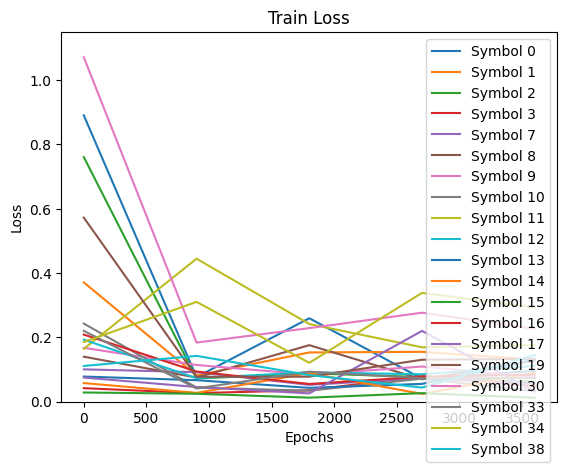

In [36]:
# plot train loss for each symbol
x = [i*900+1 for i in range(5)]
for sym in symbols:
    y = [x[0] for x in loss_log[str(sym)]]
    plt.plot(x, y, label=f"Symbol {sym}")
# have legend on top right
plt.legend(loc="upper right")
plt.ylim(0, 1.15)
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

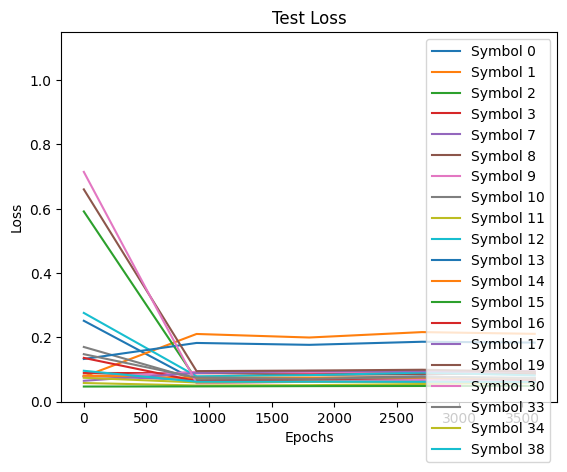

In [33]:
# plot test loss for each symbol
for sym in symbols:
    plt.plot(x, [x[1] for x in loss_log[str(sym)]], label=f"Symbol {sym}")
plt.legend()
plt.ylim(0, 1.15)
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()